In [54]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plorts
from common import *
import matplotlib
plt.style.use(['plorts', 'plorts-print', './buffer-workshop.mplstyle'])
width = 7.141
matplotlib.rcParams['figure.figsize'] = (width, width*1/3)

In [3]:
results = pd.read_sql("""
  select *
  from iperf_intervals_summed
  inner join experiments on experiments.id = iperf_intervals_summed.experiment_id
  where note in ('underutilization')""",
con=con)
results.head()

,experiment_id,start_sec,end_sec,duration_sec,bytes,bits_per_second,retransmits,omitted,sender,index,...,max_queue_depth_cells,max_queue_depth_packets,mtu_bytes,num_flows,receiver_delay,note,run_at,pacing,pacing_factor,experimenter
0,f6ab361c-ae9c-11eb-8dea-0cc47aaaaa10,0.000000,0.010600,0.010600,17956864,1.355235e+10,167,False,True,None,...,3000,26.666667,9000,2,1.0ms,underutilization,2021-05-06 11:57:57.842151,False,1.0,bspang
1,f6ab361c-ae9c-11eb-8dea-0cc47aaaaa10,0.010600,0.020089,0.009489,9175040,7.735306e+09,295,False,True,None,...,3000,26.666667,9000,2,1.0ms,underutilization,2021-05-06 11:57:57.842151,False,1.0,bspang
2,f6ab361c-ae9c-11eb-8dea-0cc47aaaaa10,0.020089,0.030076,0.009987,7864320,6.299645e+09,0,False,True,None,...,3000,26.666667,9000,2,1.0ms,underutilization,2021-05-06 11:57:57.842151,False,1.0,bspang
3,f6ab361c-ae9c-11eb-8dea-0cc47aaaaa10,0.030076,0.040063,0.009987,7864320,6.299645e+09,0,False,True,None,...,3000,26.666667,9000,2,1.0ms,underutilization,2021-05-06 11:57:57.842151,False,1.0,bspang
4,f6ab361c-ae9c-11eb-8dea-0cc47aaaaa10,0.040063,0.050075,0.010012,9175040,7.331235e+09,0,False,True,None,...,3000,26.666667,9000,2,1.0ms,underutilization,2021-05-06 11:57:57.842151,False,1.0,bspang


In [4]:
results['bits_per_second'] = 8*results.bytes/results.duration_sec

In [5]:
aggregated = results.sort_values([
    'experiment_id', 'algorithm', 'start_sec', 'end_sec'
]).groupby([results.index // 2, 'max_queue_depth_packets', 'max_queue_depth_bytes', 'num_flows', 'algorithm'], as_index=False).sum()


In [6]:
aggregated['bits_per_second'] = 8*aggregated.bytes/aggregated.duration_sec
aggregated

,max_queue_depth_packets,max_queue_depth_bytes,num_flows,algorithm,start_sec,end_sec,duration_sec,bytes,bits_per_second,retransmits,omitted,sender,max_queue_depth_cells,mtu_bytes,pacing,pacing_factor
0,17.777778,160000,2,scalable,0.010065,0.030133,0.020068,11208696,4.468286e+09,24,0,2,4000,18000,0,2.0
1,17.777778,160000,2,scalable,0.050128,0.070124,0.019996,16097452,6.440269e+09,0,0,2,4000,18000,0,2.0
2,17.777778,160000,2,scalable,0.090125,0.110132,0.020007,18790800,7.513690e+09,2,0,2,4000,18000,0,2.0
3,17.777778,160000,2,scalable,0.130130,0.150136,0.020006,20795152,8.315566e+09,0,0,2,4000,18000,0,2.0
4,17.777778,160000,2,scalable,0.170138,0.190130,0.019992,22173144,8.872807e+09,21,0,2,4000,18000,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31731,111.111111,1000000,32,scalable,1.810138,1.830146,0.020008,24984736,9.989899e+09,300,0,2,25000,18000,0,2.0
31732,111.111111,1000000,32,scalable,1.850149,1.870144,0.019995,22275540,8.912444e+09,284,0,2,25000,18000,0,2.0
31733,111.111111,1000000,32,scalable,1.890144,1.910143,0.019999,24037172,9.615350e+09,315,0,2,25000,18000,0,2.0
31734,111.111111,1000000,32,scalable,1.930142,1.950149,0.020007,23649024,9.456300e+09,280,0,2,25000,18000,0,2.0


In [72]:
def utilization_func(algorithm, bdp=166):    
    def aimd(beta):
        return lambda xs: np.minimum(beta*(1 + xs/bdp), 1)
    
    if algorithm == 'reno':
        return aimd(1/2)
    elif algorithm == 'bbr':
        return lambda xs: np.minimum(3/4 + xs/bdp, 1)
    elif algorithm == 'bbr2':
        return lambda xs: np.zeros(len(xs))
    elif algorithm == 'cubic':
        return aimd(717/1024)
    elif algorithm == 'scalable':
        return aimd(7/8)
    else:
        raise Exception("unknown algorithm")


In [73]:
aggregated['max_queue_depth_pct_bdp'] = 100.*aggregated['max_queue_depth_packets']/bdp

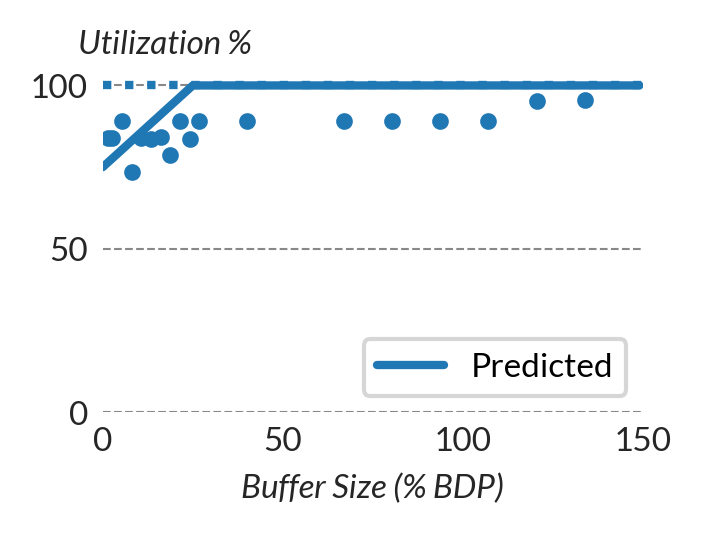

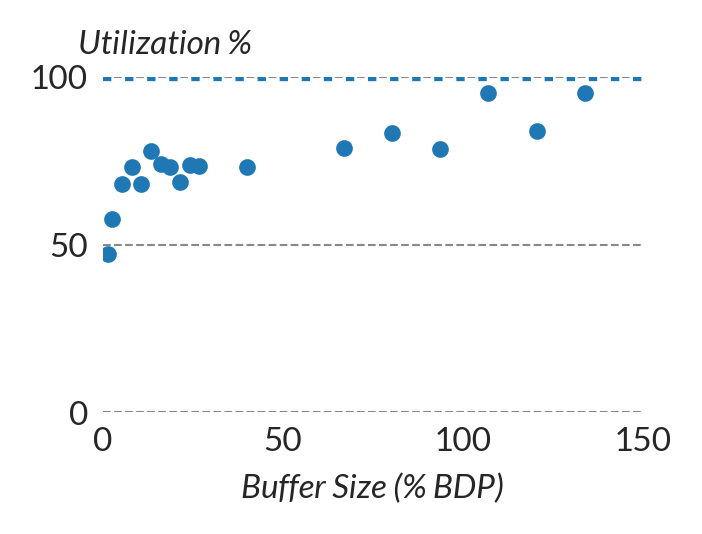

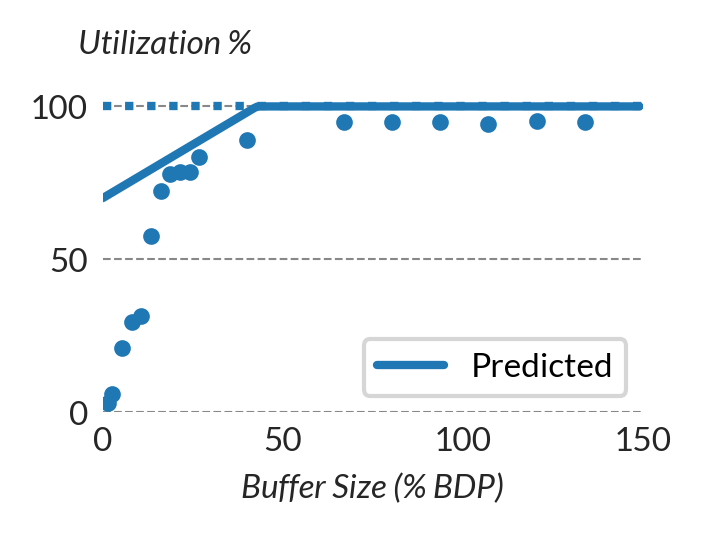

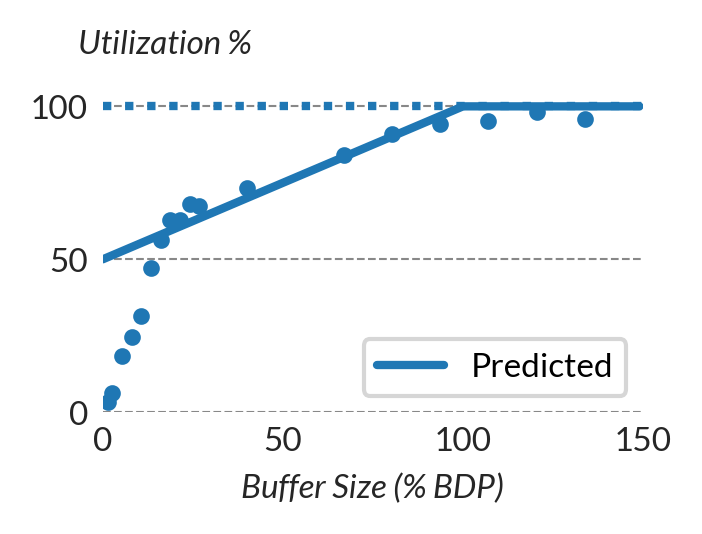

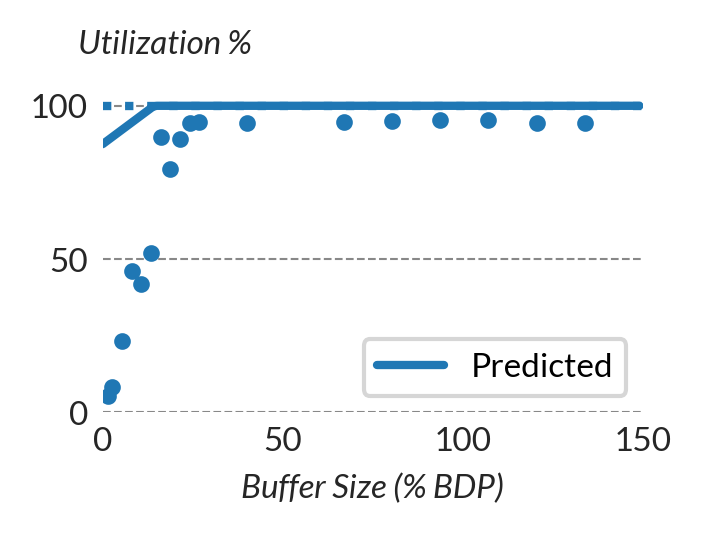

In [74]:
for alg,df in aggregated.groupby('algorithm'):
    plt.figure(figsize=(width/3, width/4))
    df = df.groupby(['num_flows','max_queue_depth_packets'],as_index=False).quantile(0.1)
    df['throughput_gbps'] = df['bits_per_second'] / 1e9
    df['utilization_pct'] = 100*df['throughput_gbps']/10
    
    if alg == 'bbr':
        # We don't actually know that BBR's maximum throughput doesn't fully utilize the link at lower
        # rates, which breaks the argument
        C = df.groupby(['num_flows','max_queue_depth_pct_bdp'],as_index=False).quantile(0.99).bits_per_second.max()
    else:
        C = 1e10
    
    plorts.scatter(df[df.num_flows == 1],
                   x="max_queue_depth_pct_bdp", y="utilization_pct",
                   color='C0', markersize=3)
    

    plt.axhline(y=100, linestyle=":")
    if alg != 'bbr2':
        xs = np.arange(0, 150)
        plt.plot(xs, 100*utilization_func(alg)(bdp*xs/100), label='Predicted')
        plt.legend(loc='lower right')
        
    plt.axis(ymin=0, xmin=0, xmax=150)
    plt.yticks([0,50,100])
    plt.xticks([0,50,100])
    plt.xlabel("Buffer Size (% BDP)")
    plt.ylabel("Utilization %")
    plorts.style_axis()
    plt.savefig(f"../figures/single_flow_utilization_{alg}.png")

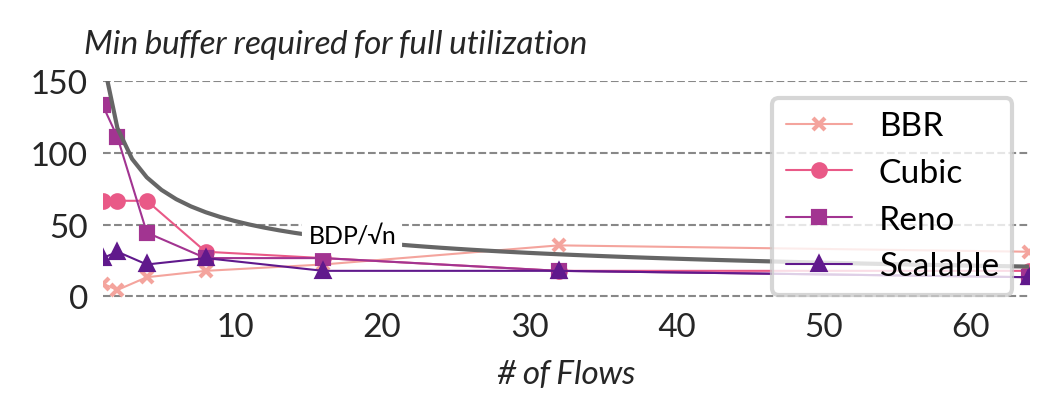

In [56]:
plt.figure(figsize=(1.5*width/3, 0.4*1.5*width/3))
df = aggregated.groupby(['algorithm', 'num_flows','max_queue_depth_packets'],as_index=False).quantile(0.1)
df = df[df.algorithm.isin(['bbr', 'cubic', 'reno', 'scalable'])]
df['formatted_algorithm'] = ['BBR' if a == 'bbr' else a.capitalize() for a in df.algorithm]
df = df[df.utilization_pct >= 85]

df = df.groupby(['algorithm', 'num_flows'], as_index=False).min()

queue_packets = df.max_queue_depth_packets.iloc[0]
queue_bytes = df.max_queue_depth_bytes.iloc[0]
plorts.plot(df,
               x="num_flows", y="max_queue_depth_packets",
               hue='formatted_algorithm',
               markersize=3, linewidth=0.5, markers=['x', 'o', 's', '^'])

ns = np.arange(1, df.num_flows.max()+1)

plt.text(15, 0.88*bdp/np.sqrt(15), 'BDP/√n',
         fontsize=6,
         bbox=dict(facecolor='white', edgecolor='white', pad=1))
plt.plot(ns, bdp/np.sqrt(ns), color='#666666', linewidth=1)

plt.legend(loc='best')

plt.axis(ymin=-1, ymax=150)
plt.yticks([0,50,100,150])
plt.xlabel("# of Flows")
plt.ylabel("Min buffer required for full utilization")
plorts.style_axis()
plt.savefig(f"../figures/min_buffer_for_full_utilization.png")

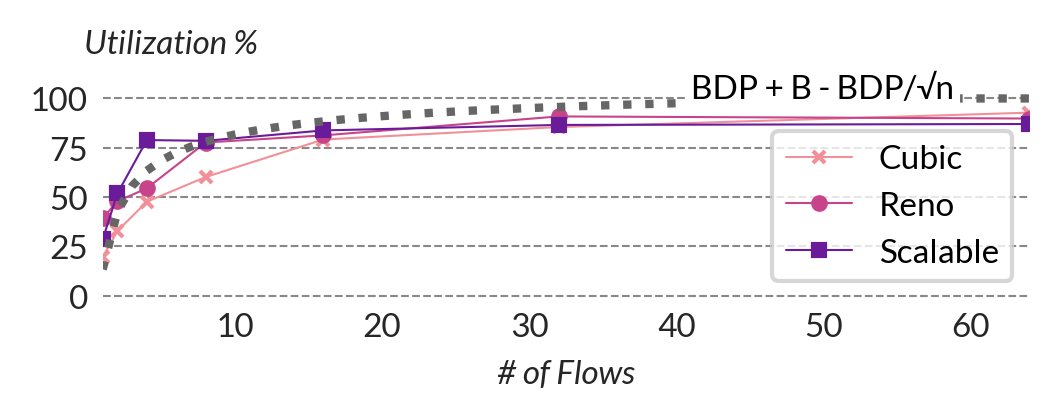

In [62]:
plt.figure(figsize=(1.5*width/3, 0.4*1.5*width/3))
df = aggregated.groupby(['algorithm', 'num_flows','max_queue_depth_packets'],as_index=False).quantile(0.01)
df = df[df.algorithm.isin(['cubic', 'reno', 'scalable'])]
df['formatted_algorithm'] = [a.capitalize() for a in df.algorithm]
df = df[df.max_queue_depth_bytes == 200000]

queue_packets = df.max_queue_depth_packets.iloc[0]
queue_bytes = df.max_queue_depth_bytes.iloc[0]
plorts.plot(df,
               x="num_flows", y="utilization_pct",
               hue='formatted_algorithm',
               markersize=3, linewidth=0.5, markers=['x', 'o', 's', '^'])

ns = np.arange(1, df.num_flows.max()+1)
plt.plot(ns, 100*np.minimum(1+queue_packets/(1*bdp)-1/np.sqrt(ns), 1), linestyle=":", color='#666666')
plt.text(41, 100*np.minimum(1+queue_packets/(bdp)-1/np.sqrt(40)+0.5, 1), 'BDP + B - BDP/√n',
         bbox=dict(facecolor='white', edgecolor='white', pad=1))

plt.axis(ymin=-1)
plt.yticks([0,25,50,75,100])
plt.xlabel("# of Flows")
plt.ylabel("Utilization %")
plt.legend(loc='lower right')
plorts.style_axis()
plt.savefig(f"../figures/utilization_num_flows.png")

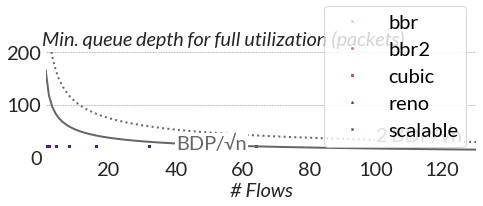

In [194]:
plt.figure(figsize=(width, 0.4*width))
plorts.scatter(aggregated[aggregated.max_queue_depth_bytes == 200000],
               x="num_flows", y="max_queue_depth_packets",
               hue='algorithm',
               markersize=2, markers=['x', 'o', 's', '^'])

bdp = 166
ns = np.arange(1,131)
plt.plot(ns, , color='#666666')
plt.text(40, bdp/np.sqrt(40)-10, 'BDP/√n', color='#666666', bbox=dict(facecolor='white', edgecolor='white', pad=1),
         fontname='sans')
plt.plot(ns, 2*bdp/np.sqrt(ns), color='#666666', linestyle=":")
plt.text(100, bdp/np.sqrt(100)+15, '2 BDP/√n', color='#666666', bbox=dict(facecolor='white', edgecolor='white', pad=1),
        fontname='sans')

plt.xlabel("# Flows")
plt.ylabel("Min. queue depth for full utilization (packets)")
plorts.style_axis()
plt.legend(loc='best')
plt.axis(xmax=130, ymin=0, ymax=200)

plt.savefig("/Users/bspang/code/imc2020-paper/figures/sqrt-n-rule-tested.png")